In [1]:
# Standard library imports
import csv
import itertools
import os
import os.path
import random
from glob import glob
from pathlib import Path
import zlib
import importlib

# Third-party imports
import cv2
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import skimage
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from skimage.transform import resize
from sklearn import model_selection
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import (KFold, StratifiedKFold, cross_val_score,
                                     learning_curve, train_test_split)
from sklearn.utils import class_weight, shuffle
from tqdm import tqdm

# Keras-specific imports
import keras
from keras import backend as K
from keras import layers, models, optimizers
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import (Activation, AveragePooling2D, BatchNormalization,
                          Conv2D, Dense, Dropout, Flatten, Lambda, MaxPool2D,
                          MaxPooling2D)
from keras.models import Model, Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.utils import to_categorical

# Custom imports
import fit
import evaluate
import viz

%matplotlib inline

In [2]:
imageSize=50
train_dir = "/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/archive/asl_alphabet_train/asl_alphabet_train"
test_dir =  "/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/archive/asl_alphabet_test/asl_alphabet_test"

def get_data(folder):
    # Load data and labels from parent folder
    X = []
    y = []
    for folderName in os.listdir(folder):
        full_path = os.path.join(folder, folderName)  # Create full path to the item
        if os.path.isdir(full_path):  # Check if the item is a directory
            if not folderName.startswith('.'):
                if folderName in ['A']:
                    label = 0
                elif folderName in ['B']:
                    label = 1
                elif folderName in ['C']:
                    label = 2
                elif folderName in ['D']:
                    label = 3
                elif folderName in ['E']:
                    label = 4
                elif folderName in ['F']:
                    label = 5
                elif folderName in ['G']:
                    label = 6
                elif folderName in ['H']:
                    label = 7
                elif folderName in ['I']:
                    label = 8
                elif folderName in ['J']:
                    label = 9
                elif folderName in ['K']:
                    label = 10
                elif folderName in ['L']:
                    label = 11
                elif folderName in ['M']:
                    label = 12
                elif folderName in ['N']:
                    label = 13
                elif folderName in ['O']:
                    label = 14
                elif folderName in ['P']:
                    label = 15
                elif folderName in ['Q']:
                    label = 16
                elif folderName in ['R']:
                    label = 17
                elif folderName in ['S']:
                    label = 18
                elif folderName in ['T']:
                    label = 19
                elif folderName in ['U']:
                    label = 20
                elif folderName in ['V']:
                    label = 21
                elif folderName in ['W']:
                    label = 22
                elif folderName in ['X']:
                    label = 23
                elif folderName in ['Y']:
                    label = 24
                elif folderName in ['Z']:
                    label = 25
                elif folderName in ['del']:
                    label = 26
                elif folderName in ['nothing']:
                    label = 27
                elif folderName in ['space']:
                    label = 28           
                else:
                    label = 29
                for image_filename in tqdm(os.listdir(full_path)):
                    img_file = cv2.imread(os.path.join(full_path, image_filename))
                    if img_file is not None:
                        img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                        img_arr = np.asarray(img_file)
                        X.append(img_arr)
                        y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [3]:

X_train, Y_train = get_data(train_dir)


100%|██████████| 3000/3000 [00:05<00:00, 506.27it/s]


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, shuffle=True, random_state=23) 


Y_trainHot = to_categorical(Y_train, num_classes = 30)

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y_trainHot = to_categorical(y_train, num_classes = 30)
y_testHot = to_categorical(y_test, num_classes = 30)


In [5]:

labels = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z", "delete", "nothing", "space"]


In [6]:
np.save('/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/X_train.npy', X_train)
np.save('/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/X_test.npy', X_test)
np.save('/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/y_trainHot.npy', y_trainHot)
np.save('/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/y_testHot.npy', y_testHot)
np.save('/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/y_train.npy', y_train)
np.save('/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/y_test.npy', y_test)

In [7]:
importlib.reload(viz)

<module 'viz' from '/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/signvision-ai/viz.py'>

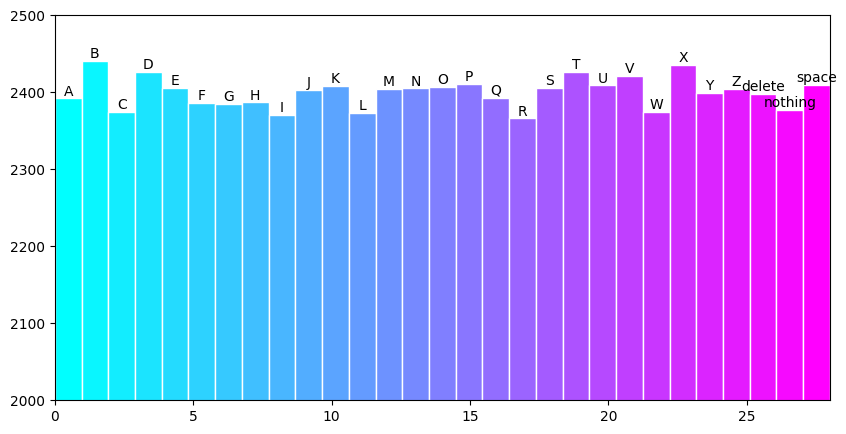

In [8]:
viz.distPlot(y_train, labels)

In [9]:
import plotly.express as px
import numpy as np

def distPlot(y_train, labels):
    # Count occurrences of each class in y_train
    unique, counts = np.unique(y_train, return_counts=True)
    
    # Create a dictionary mapping numeric class to string label
    label_dict = {i: label for i, label in enumerate(labels)}
    
    # Map counts to the corresponding label strings and sort alphabetically by labels
    label_counts = {label_dict[key]: value for key, value in sorted(zip(unique, counts), key=lambda x: label_dict[x[0]])}

    # Create the histogram using the counted and sorted data
    fig = px.bar(x=list(label_counts.keys()), y=list(label_counts.values()),
                 labels={'x': 'Class Labels', 'y': 'Frequency'}, 
                 title="Distribution of Classification Labels")
    
    # Apply a color gradient based on position
    cm = px.colors.sequential.Purples
    colors = [cm[int(i / len(label_counts) * (len(cm) - 1))] for i in range(len(label_counts))]
    fig.update_traces(marker_color=colors)
    
    # Add text labels on top of each bar
    # for x, y in label_counts.items():
      #  fig.add_annotation(x=x, y=y, text=str(y), showarrow=False, yshift=10)
    
    # Adjust layout and display the plot with a transparent background
    fig.update_layout(
        yaxis_title="Count of Labels",
        paper_bgcolor='rgba(0, 24, 30, 1)',  # Transparent background color
        plot_bgcolor='rgba(0, 24, 30, 1)',   # Transparent plot area
        font=dict(color='white')
    )
    fig.write_html("distPlot.html", include_plotlyjs='cdn')  # Save as interactive HTML
    fig.write_image("distPlot.png")  # Save as PNG image
    fig.show()

# Example usage:
# y_train = np.random.choice(29, size=60000, replace=True)  # Simulate data
# labels = ['Label {}'.format(i) for i in range(29)]  # Simulate label names
# distPlot(y_train, labels)


In [10]:
distPlot(y_train, labels)

In [11]:
from collections import Counter
counter = Counter(y_train)

sorted(counter.items())


[(0, 2392),
 (1, 2441),
 (2, 2375),
 (3, 2426),
 (4, 2406),
 (5, 2386),
 (6, 2385),
 (7, 2387),
 (8, 2371),
 (9, 2403),
 (10, 2408),
 (11, 2373),
 (12, 2404),
 (13, 2405),
 (14, 2407),
 (15, 2411),
 (16, 2393),
 (17, 2366),
 (18, 2406),
 (19, 2426),
 (20, 2409),
 (21, 2421),
 (22, 2375),
 (23, 2436),
 (24, 2399),
 (25, 2404),
 (26, 2398),
 (27, 2377),
 (28, 2410)]

In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [13]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_scaled = scaler.transform(X_test.reshape(X_test.shape[0], -1))

In [14]:
# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


In [15]:
np.save('/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/X_train_pca.npy', X_train_pca)
np.save('/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/X_test_pca.npy', X_test_pca)


In [16]:
X_test_pca = np.load("/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/X_test_pca.npy")
y_test = np.load("/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/y_test.npy")
y_testHot = np.load("/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/y_testHot.npy")
X_test = np.load("/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/X_test.npy")


X_train_pca = np.load("/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/X_train_pca.npy")
y_train = np.load("/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/y_train.npy")
y_trainHot = np.load("/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/y_trainHot.npy")
X_train = np.load("/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/data/X_train.npy")

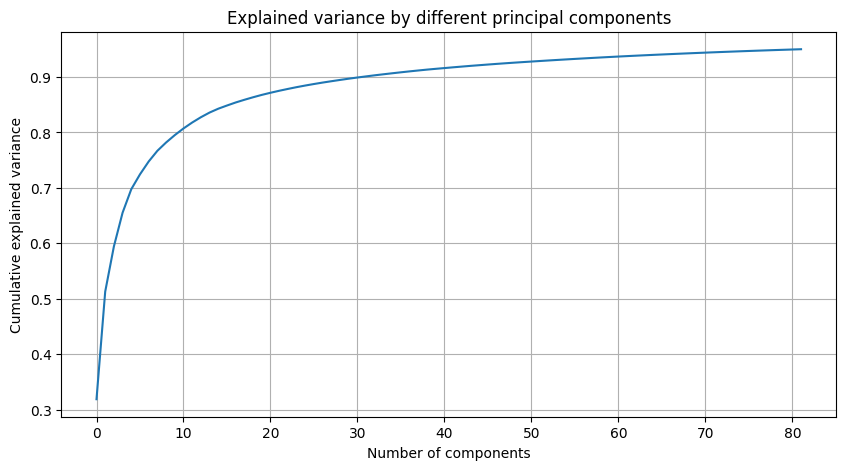

In [17]:
# Explained variance plot
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Explained variance by different principal components')
plt.grid(True)
plt.show()

In [23]:
mapping = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'del', 27: 'nothing', 28: 'space'}
classes = np.unique(y_train)

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {classes[i]: class_weights[i] for i in range(len(classes))}

weight_path = 'keras_pre-trained_models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
# weight_path2 = 'keras_pre-trained_models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pretrained = VGG16(weights = weight_path, include_top=False, input_shape=(imageSize, imageSize, 3))
# pretrained_model_2 = InceptionV3(weights = weight_path2, include_top=False, input_shape=(imageSize, imageSize, 3))
optimizer1 = keras.optimizers.Adam()
# optimizer2 = keras.optimizers.RMSprop(lr=0.0001)

In [24]:
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

In [25]:
importlib.reload(fit)

<module 'fit' from '/Users/mnorton/Desktop/College/Grad Victory Lap/CMSE 890/signvision-ai/fit.py'>

In [21]:
history1, model1 = fit.scaled1dNetwork(X_train_pca, y_trainHot,0.2,class_weight_dict,30,20,optimizer1)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 82)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        42,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │         7,710 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 181,534 (709.12 KB)

 Trainable params: 181,534 (709.12 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1740/1740 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1617 - loss: 6.7881 - val_accuracy: 0.5562 - val_loss: 2.1393
Epoch 2/20
1740/1740 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4440 - loss: 2.3249 - val_accuracy: 0.6752 - val_loss: 1.7388
Epoch 3/20
1740/1740 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5313 - loss: 2.0835 - val_accuracy: 0.6955 - val_loss: 1.6478
Epoch 4/20
1740/1740 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5659 - loss: 1.9799 - val_accuracy: 0.7387 - val_loss: 1.5854
Epoch 5/20
1740/1740 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5880 - loss: 1.9332 - val_accuracy: 0.7498 - val_loss: 1.5333
Epoch 6/20
1740/1740 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6012 - loss: 1.8919 - val_accuracy: 0.7764 - val_loss: 1.5202
Epoch 7/20
1740/1740 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6172 - loss: 1.8630 - val_accuracy: 0.7761 - val_loss: 1.4984
Epoch 8/20
1740/1740 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6203 - loss: 1.8468 - 

In [26]:
history, model = fit.pretrainedNetwork(X_train, y_trainHot, 0.3,pretrained,weight_path,class_weight_dict,30,10,optimizer1)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 50, 50, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 50, 50, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 30)             │        15,390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,730,078 (56.19 MB)

 Trainable params: 15,390 (60.12 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 496s 325ms/step - accuracy: 0.4206 - loss: 2.4635 - val_accuracy: 0.7447 - val_loss: 1.2966
Epoch 2/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 521s 342ms/step - accuracy: 0.7674 - loss: 1.1771 - val_accuracy: 0.8152 - val_loss: 0.9023
Epoch 3/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 513s 337ms/step - accuracy: 0.8290 - loss: 0.8503 - val_accuracy: 0.8563 - val_loss: 0.7110
Epoch 4/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 507s 333ms/step - accuracy: 0.8648 - loss: 0.6785 - val_accuracy: 0.8774 - val_loss: 0.5942
Epoch 5/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 534s 351ms/step - accuracy: 0.8860 - loss: 0.5726 - val_accuracy: 0.8912 - val_loss: 0.5164
Epoch 6/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 612s 402ms/step - accuracy: 0.9028 - loss: 0.4930 - val_accuracy: 0.9083 - val_loss: 0.4531
Epoch 7/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 658s 432ms/step - accuracy: 0.9167 - loss: 0.4305 - val_accuracy: 0.9191 - val_loss: 0.4082
Epoch 8/10
1523/1523 ━━━━━━━━━━━━━━━━━━━━ 682s 448ms/step - ac

In [22]:
model1.save('assets/models/ASL_DNN_1D.keras')
model1.save("assets/models/ASL_DNN_1D.h5")

In [1]:
model.save('assets/models/ASL_DNN_FD.keras')
model.save("assets/models/ASL_DNN_FD.h5")

NameError: name 'model' is not defined

In [28]:
# Predict the classes for the FD test set
y_predFD = model.predict(X_test)

# If the predictions are probabilities (as with some models), 
# you'll need to convert to predicted class labels by taking the argmax
if y_predFD.ndim > 1:
    y_predFD = np.argmax(y_predFD, axis=1)

# Ensure 'y_test' is not one-hot encoded. If it is, convert it:
if y_test.ndim > 1:
    y_testFD = np.argmax(y_test, axis=1)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_predFD)

print(f"Accuracy score: {accuracy}")

544/544 ━━━━━━━━━━━━━━━━━━━━ 131s 241ms/step
Accuracy score: 0.9358045977011494


In [ ]:
from sklearn.metrics import classification_report
print('\n', classification_report(np.where(y_testHot > 0)[1], np.argmax(model1.predict(X_test_pca), axis=1), target_names=labels), sep='') 

  1/544 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step

544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step

              precision    recall  f1-score   support

           A       0.76      0.82      0.79       608
           B       0.87      0.81      0.84       559
           C       0.90      0.91      0.90       625
           D       0.93      0.72      0.82       574
           E       0.82      0.71      0.76       594
           F       0.82      0.80      0.81       614
           G       0.85      0.85      0.85       615
           H       0.90      0.92      0.91       613
           I       0.87      0.88      0.87       629
           J       0.92      0.85      0.88       597
           K       0.86      0.90      0.88       592
           L       0.93      0.81      0.86       627
           M       0.91      0.64      0.75       596
           N       0.82      0.93      0.87       595
           O       0.77      0.88      0.82       593
           P       0.90      0.85      0.87       589
           Q       0.86      0.98    

In [59]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion matrix', cmap=custom_cmap,
                        save_path=None, transparent=True):
    cm = confusion_matrix(y_true, y_pred)

    np.savetxt('confusion_matrix.csv', cm, delimiter=',', fmt='%d')

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    
    fig.patch.set_alpha(0 if transparent else 1)
    ax.set_facecolor('none' if transparent else 'white')
    
    ax.spines['top'].set_color('white')
    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.title.set_color('white')

    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", color='white')
    plt.setp(ax.get_yticklabels(), color='white')
    
    # Define the format and threshold for text color contrast
    fmt = 'd'
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            color = "white" if np.mean(im.cmap(im.norm(cm[i, j]))) < 0.5 else "black"
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color=color)
    
    fig.tight_layout()

    if save_path:
        fig.savefig(save_path, dpi=1000, transparent=transparent, bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    return ax


In [55]:
from matplotlib.colors import LinearSegmentedColormap

# Create a custom colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", ["#003845","#DDE6E6"])


In [52]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_testHot, axis=1)

102/544 ━━━━━━━━━━━━━━━━━━━━ 4:24 597ms/step

KeyboardInterrupt: 

Plot saved to cm.png


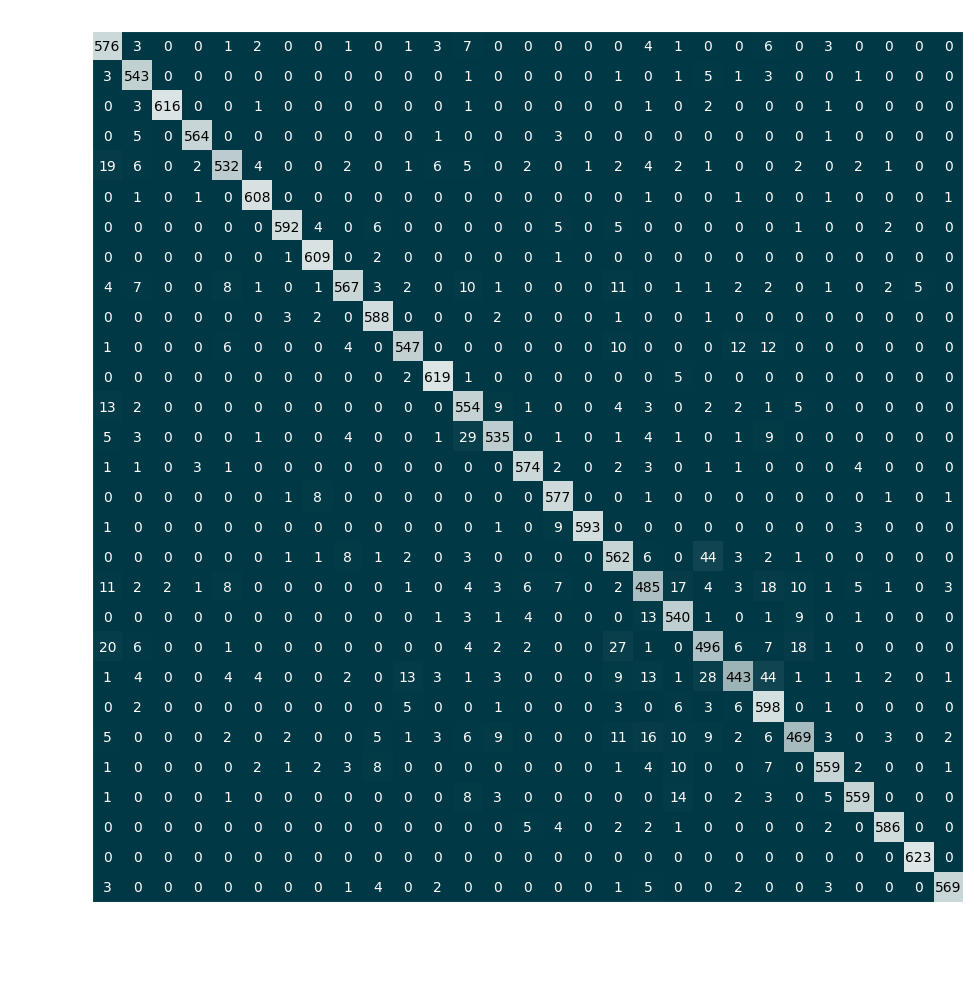

In [60]:

plot_confusion_matrix(y_true, y_pred, classes=labels,cmap=custom_cmap, save_path="cm.png")

plt.show()

In [ ]:
# Predict the classes for the FD test set
y_predFD = model.predict(X_test)

# If the predictions are probabilities (as with some models), 
# you'll need to convert to predicted class labels by taking the argmax
if y_predFD.ndim > 1:
    y_predFD = np.argmax(y_predFD, axis=1)

# Ensure 'y_test' is not one-hot encoded. If it is, convert it:
if y_test.ndim > 1:
    y_testFD = np.argmax(y_test, axis=1)

# Calculate the accuracy score
accuracy = accuracy_score(y_testFD, y_predFD)

print(f"Accuracy score: {accuracy}")


In [ ]:

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_predFD)

print(f"Accuracy score: {accuracy}")


In [ ]:
evaluate.evaluate(model1, history1, X_test, y_testHot, mapping)

ValueError: as_list() is not defined on an unknown TensorShape.